# 使用TensorFlow hub 进行文本分类

In [1]:
import os 
import numpy as np
import tensorflow as tf 
import tensorflow_hub as hub 
import tf_keras
import tensorflow_datasets as tfds 

print("version:", tf.__version__)
print("Eager mode:", tf.executing_eagerly())
print("Hub version :", hub.__version__)
print("GPU is ","Available" if tf.config.list_physical_devices("GPU")else "NOT available")



version: 2.18.0
Eager mode: True
Hub version : 0.16.1
GPU is  NOT available


## 下载IMDB 数据集 

In [2]:
train_data,validation_data, test_data = tfds.load(
    name='imdb_reviews', 
    split=('train[:60%]', 'train[60%:]', 'test'), 
    as_supervised=True
)
# split the traing set into 60% and 40% for traning and validation respcectively

In [3]:
train_examples_batch,train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [4]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

使用tensorflow hub 的预训练文本向量模型 google/nnlm-en-dim50/2

·还有其他预训练文本嵌入向量 google/nnlm-en-dim128/2

创建使用tensorflow 模型嵌入（embed）语句 的keras层
嵌入的输出形状为 （num_examples, embedding_dimension）
 

In [5]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding,input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])


<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

## 构建完整模型

In [6]:
model = tf_keras.Sequential([
    hub_layer, 
    # hub.KerasLayer(embedding,input_shape=[], 
                        #    dtype=tf.string, trainable=True),
    tf_keras.layers.Dense(16,activation='relu'), 
    tf_keras.layers.Dense(1)
    
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191433 (183.84 MB)
Trainable params: 48191433 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 模型编译 
损失函数和优化器

In [7]:
model.compile(optimizer='adam',
              loss=tf_keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])


In [8]:
history = model.fit(train_data.shuffle(10000).batch(521),
                     epochs=10, 
                     validation_data=validation_data.batch(521), 
                     verbose=2)


Epoch 1/10



29/29 - 13s - loss: 0.6449 - accuracy: 0.5605 - val_loss: 0.5922 - val_accuracy: 0.6289 - 13s/epoch - 451ms/step
Epoch 2/10
29/29 - 11s - loss: 0.5171 - accuracy: 0.7209 - val_loss: 0.4750 - val_accuracy: 0.7739 - 11s/epoch - 380ms/step
Epoch 3/10
29/29 - 11s - loss: 0.3775 - accuracy: 0.8421 - val_loss: 0.3838 - val_accuracy: 0.8337 - 11s/epoch - 393ms/step
Epoch 4/10
29/29 - 11s - loss: 0.2718 - accuracy: 0.8960 - val_loss: 0.3362 - val_accuracy: 0.8528 - 11s/epoch - 379ms/step
Epoch 5/10
29/29 - 11s - loss: 0.1993 - accuracy: 0.9302 - val_loss: 0.3163 - val_accuracy: 0.8575 - 11s/epoch - 385ms/step
Epoch 6/10
29/29 - 11s - loss: 0.1465 - accuracy: 0.9547 - val_loss: 0.3106 - val_accuracy: 0.8617 - 11s/epoch - 388ms/step
Epoch 7/10
29/29 - 11s - loss: 0.1067 - accuracy: 0.9709 - val_loss: 0.3092 - val_accuracy: 0.8704 - 11s/epoch - 372ms/step
Epoch 8/10
29/29 - 11s - loss: 0.0769 - accuracy: 0.9817 - val_loss: 0.3159 - val_accuracy: 0.8682 - 11s/epoch - 379ms/step
Epoch 9/10
29/29 - 

In [9]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f"%(name,value))
    

49/49 - 2s - loss: 0.3627 - accuracy: 0.8512 - 2s/epoch - 48ms/step
loss: 0.363
accuracy: 0.851


In [10]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
import matplotlib.pyplot as plt

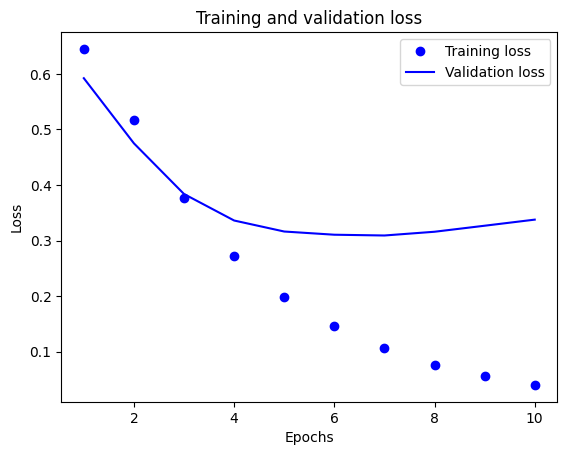

In [16]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

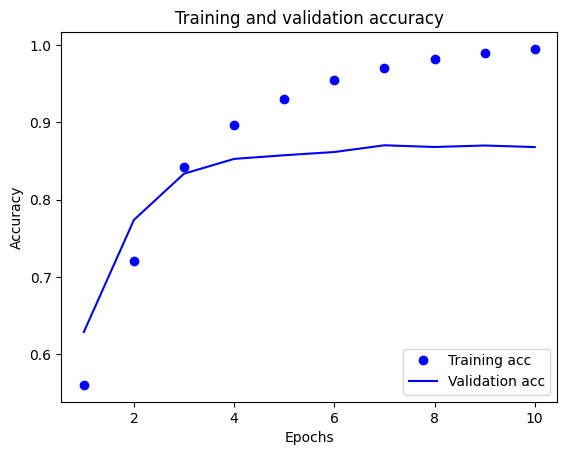

In [17]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()